In [3]:
import cv2
import sklearn.mixture
import matplotlib.pyplot as plt
import numpy as np
import igraph

In [4]:
class GrabCut:
    def __init__(self, image, gamma = 50, option = 0, num_components = 5, bbox = None):
        
        '''
        Class constructor
        Input:
            image - H x W x 3 - input image
            bbox - list - bounding box coordinates
            gamma - scalar - gamma value for grabcut
            option - scalar 
                0 - 4 neighborhood
                1 - 8 neighborhood
            num_components - scalar - number of gaussian components
        Returns:
            None
        '''
        self.image = image
        if bbox is None:
            r = cv2.selectROI(self.image) 
            bbox = [r[0], r[1], r[0] + r[2], r[1] + r[3]]
            self.bbox = bbox
        else:
            self.bbox = bbox
            
        self.option = option
        self.x1 = int(bbox[0])
        self.x2 = int(bbox[2])
        self.y1 = int(bbox[1])
        self.y2 = int(bbox[3])
        
        self.gamma = gamma
        self.mask = None
        self.graph = None
        self.num_components = num_components
        
        self.bg_gmm = None
        self.fg_gmm = None
        
        self.create_mask_init()
        self.create_graph_image()
        cv2.destroyAllWindows()
        
    def create_mask_init(self):
        '''
        Creates initial mask
            0 - bg
            1 - probably bg
            2 - probably fg
            3 - fg
        '''
        
        mask = np.zeros((self.image.shape[0], self.image.shape[1]))
        mask[ self.y1:self.y2, self.x1:self.x2] = 2
        self.mask = mask
        
    
    def GMMPrediction(self):
        '''
        Function to cluster images sections using gaussian mixture models  
        '''
        image = self.image
        mask = self.mask
        
        bg_mask = np.logical_or(mask == 0 , mask == 1)
        fg_mask = np.logical_or(mask == 2 , mask == 3)
        
        
        image_mask_vector_bg = image[bg_mask, :]
        image_mask_vector_fg = image[fg_mask, :]
        
        gmm_model_bg = sklearn.mixture.GaussianMixture(n_components = self.num_components).fit(image_mask_vector_bg)
        gmm_model_fg = sklearn.mixture.GaussianMixture(n_components = self.num_components).fit(image_mask_vector_fg)

        image_vector = image.reshape((-1, 3))

        neg_log_likelihood_bg = -gmm_model_bg.score_samples(image_vector)
        neg_log_likelihood_fg = -gmm_model_fg.score_samples(image_vector)

        self.bg_gmm = neg_log_likelihood_bg.reshape((image.shape[0], image.shape[1]))
        self.fg_gmm = neg_log_likelihood_fg.reshape((image.shape[0], image.shape[1]))
        
    
    
    def create_graph_image(self):
        
        self.graph = igraph.Graph()
        self.graph.add_vertices(self.image.shape[0] * self.image.shape[1] + 2)
    
    def calc_beta_value(self):
        '''
        Function to calculate beta value used in neighboring edge weight
        '''

        image = self.image
        height = image.shape[0]
        width = image.shape[1]

        diff_up = np.sum(np.sum(np.square(image[1:height - 1, :] - image[:height - 2, :]), axis = 2))
        diff_side = np.sum(np.sum(np.square(image[:, 1:width - 1] - image[:, :width - 2]), axis = 2))
        diff_diag = np.sum(np.sum(np.square(image[1:height - 1, 1:width - 1] - image[:height - 2, :width - 2]), axis = 2))
        diff_lower_diag = np.sum(np.sum(np.square(image[:height - 2, 1:width - 1] - image[1:height - 1, :width - 2]), axis = 2))

        # 2 * (h - 1)(w - 1) + (h - 1)w + (w - 1)h = 4hw - 3h - 3w + 2
        beta = (1 / 2) * (2 * (height - 1) * (width - 1) + height * (width - 1) + (height - 1) * width ) * (1 / (diff_diag + diff_lower_diag + diff_up + diff_side))

        return beta
    
    def add_graph_edges(self):
        
        beta = self.calc_beta_value()
        image = self.image
        height = image.shape[0]
        width = image.shape[1]
        
        sink_node = int(image.shape[0]*image.shape[1] + 1)
        source_node = int(0)
        
        gamma = self.gamma
        edges = []
        weights = []
        mask = self.mask
        
        for row in range(height):
            for column in range(width):
        
        # bottom pixel weight

                if (row + 1) < height:
                    edges.append((row*width + column + 1, (row + 1)*width + column + 1))

                    if mask[row + 1, column] == mask[row, column]:
                        weights.append(0)
                    else:
                        weights.append(gamma*np.exp(-beta * np.sum(np.square(image[row + 1, column] - image[row, column]))))

                #right pixel
                if (column + 1) < width:
                    edges.append((row*width + column + 1, (row)*width + column + 2))

                    if mask[row, column + 1] == mask[row, column]:
                        weights.append(0)
                    else:
                        weights.append(gamma*np.exp(-beta * np.sum(np.square(image[row, column + 1] - image[row, column]))))

                # diagonal pixel
                
                if (column + 1) < width and (row + 1) < height and self.option == 1:
                    edges.append(((row + 1)*width + column + 2, (row)*width + column + 1))

                    if mask[row + 1, column + 1] == mask[row, column]:
                        weights.append(0)
                    else:
                        weights.append(gamma*np.exp(-beta * np.sum(np.square(image[row + 1, column + 1] - image[row, column]))))

        K = 1 + max(weights)
        
        for row in range(height):
            for column in range(width):
                
                if mask[row, column] == 1 or mask[row, column] == 2:
                    edges.append((source_node, int(row*width + column + 1)))
                    weights.append(self.bg_gmm[ row, column])

                    edges.append((sink_node, int(row*width + column + 1)))
                    weights.append(self.fg_gmm[ row, column])
                
                elif mask[row, column] == 0:
                    edges.append((source_node, int(row*width + column + 1)))
                    weights.append(0)

                    edges.append((sink_node, int(row*width + column + 1)))
                    weights.append(K)
                else:
                    edges.append((source_node, int(row*width + column + 1)))
                    weights.append(K)

                    edges.append((sink_node, int(row*width + column + 1)))
                    weights.append(0)

                
        
        self.graph.add_edges(edges)
        self.graph.es['weight'] = weights

    def update_mask(self, partition_source):
        '''
        Update mask after st mincut
        ''' 
        
        mask = np.zeros((self.image.shape[0], self.image.shape[1]))
        mask[ self.y1:self.y2, self.x1:self.x2] = 1
        mask2 = mask.copy()
        mask2[self.y1:self.y2, self.x1:self.x2] = 1
        bbox_width = image.shape[1]
        
        #print(len(partition_source))
        # removing source node from partition
        partition_source = np.array(partition_source, dtype = int)
        
        
        partition_source = partition_source - 1
        mask_partition = partition_source >= 0
        
        partition_source = partition_source[mask_partition]
        
        
        fg_row = partition_source // bbox_width
        fg_col = partition_source % bbox_width

        mask[fg_row, fg_col] = 2
        self.mask = mask * mask2 
    
    def generate_image_mask(self):
        '''
        Generate segmented image
        '''
        
        masked_image = np.zeros(self.image.shape)
        mask = np.logical_or(self.mask == 2, self.mask == 3)
        for i in range(3):
            masked_image = self.image[:, :, i] * mask
        
        return masked_image
        
    def grabCut(self):
        
        
        for i in range(5):
            self.GMMPrediction()
            self.add_graph_edges()
            partition_source, partition_terminal = self.graph.st_mincut( int(0), image.shape[0]*image.shape[1] + 1, self.graph.es['weight'])
            
            self.update_mask(partition_source)
            
            masked_image = self.generate_image_mask()
            masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
            plt.imshow(masked_image)
            plt.show()
            
        

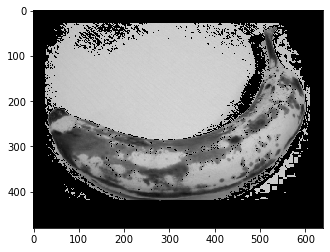

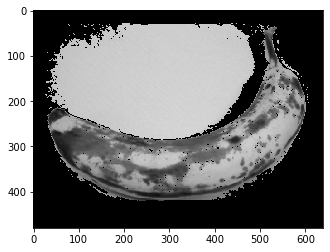

KeyboardInterrupt: 

In [5]:
if __name__ == "__main__":
    
    name = 'banana1'
    image_name = './data/images/%s.jpg' % (name)
    bbox_name = './data/bboxes/%s.txt' % (name)
    bbox = np.loadtxt(bbox_name, delimiter = ' ')
    image = cv2.imread(image_name)
    gamma = 50
    option = 1
    num_components = 5
    grabcut_object = GrabCut(image, gamma, option, num_components)
    grabcut_object.grabCut()